In [46]:
# https://ai.plainenglish.io/audio-data-music-genre-classification-8fe58cc9444e
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification, TrainingArguments
import torchaudio
import torchaudio.transforms as T
import torch
import numpy as np
import os

In [47]:
# model_id = "ntu-spml/distilhubert"
model_path = 'distilhubert-finetuned-2sec_voice/checkpoint-726'
feature_extractor = AutoFeatureExtractor.from_pretrained(
    model_path, do_normalize=True, return_attention_mask=True
)

sampling_rate = feature_extractor.sampling_rate

In [48]:
sampling_rate = feature_extractor.sampling_rate
sampling_rate

16000

In [49]:
from datasets import load_dataset, Audio

dataset = load_dataset('audiofolder', data_dir='Rebetika_2sec')
dataset_whole = load_dataset('audiofolder', data_dir='Rebetika_whole')

Resolving data files:   0%|          | 0/1162 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/181 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/94 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

In [50]:
# resample audio files to desired sample rate
dataset = dataset.cast_column('audio', Audio(sampling_rate=sampling_rate))
dataset_whole = dataset_whole.cast_column('audio', Audio(sampling_rate=sampling_rate))

In [51]:
max_duration = 10.0

def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=int(feature_extractor.sampling_rate * max_duration),
        truncation=True,
        return_attention_mask=True,
    )
    return inputs

In [52]:
dataset_encoded = dataset.map(
    preprocess_function,
    remove_columns=['audio'],
    batched=True,
    batch_size=100,
    num_proc=1,
)
dataset_encoded

DatasetDict({
    train: Dataset({
        features: ['label', 'input_values', 'attention_mask'],
        num_rows: 1162
    })
    test: Dataset({
        features: ['label', 'input_values', 'attention_mask'],
        num_rows: 181
    })
})

In [53]:
dataset_whole_encoded = dataset_whole.map(
    preprocess_function,
    remove_columns=['audio'],
    batched=True,
    batch_size=100,
    num_proc=1,
)
dataset_whole_encoded

DatasetDict({
    train: Dataset({
        features: ['label', 'input_values', 'attention_mask'],
        num_rows: 94
    })
    test: Dataset({
        features: ['label', 'input_values', 'attention_mask'],
        num_rows: 19
    })
})

In [54]:
id2label_fn = dataset['train'].features['label'].int2str
id2label_fn(dataset['train'][50]['label'])

'Bellou'

In [55]:
id2label = {
    str(i): id2label_fn(i)
    for i in range(len(dataset_encoded["train"].features["label"].names))
}
label2id = {v: k for k, v in id2label.items()}

id2label['2']

'Ninou'

In [56]:
num_labels = len(id2label)

model = AutoModelForAudioClassification.from_pretrained(
    model_path,
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label,
)

In [57]:
dataset_encoded['train'][50]['input_values']

[0.30225393176078796,
 0.5166130065917969,
 0.4574105441570282,
 0.4846798777580261,
 0.4330848455429077,
 0.4226987361907959,
 0.3660241961479187,
 0.3304067552089691,
 0.25910502672195435,
 0.20576070249080658,
 0.14196449518203735,
 0.0876540094614029,
 0.021985232830047607,
 -0.03806686028838158,
 -0.08990288525819778,
 -0.12814471125602722,
 -0.1538899689912796,
 -0.17227569222450256,
 -0.1850513070821762,
 -0.19385090470314026,
 -0.19327713549137115,
 -0.1900152713060379,
 -0.1790214478969574,
 -0.1772666871547699,
 -0.17903149127960205,
 -0.19000257551670074,
 -0.20295554399490356,
 -0.22833441197872162,
 -0.2610178589820862,
 -0.31459417939186096,
 -0.37686866521835327,
 -0.43964383006095886,
 -0.4925380051136017,
 -0.532628059387207,
 -0.5688258409500122,
 -0.599540114402771,
 -0.6029958128929138,
 -0.5847737789154053,
 -0.5426120758056641,
 -0.4802676737308502,
 -0.39772042632102966,
 -0.29523926973342896,
 -0.1793767660856247,
 -0.060017459094524384,
 0.06282118707895279,
 0

In [58]:
t = torch.FloatTensor( dataset_encoded['train'][50]['input_values'] )
tt = t.view(1, t.shape[0])
print(tt.shape)

torch.Size([1, 32000])


In [59]:
model.eval()

HubertForSequenceClassification(
  (hubert): HubertModel(
    (feature_extractor): HubertFeatureEncoder(
      (conv_layers): ModuleList(
        (0): HubertGroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): HubertFeatureProjection(
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): HubertEncoder(
      (pos_conv_embed): HubertPositionalConvEmbedding(

In [60]:
# run accuracy on test set
test_results = []
test_accuracy = []
for datapoint in dataset_encoded['test']:
    t = torch.FloatTensor( datapoint['input_values'] )
    c = model( t.view(1, t.shape[0]) )['logits'].argmax()
    test_results.append( c )
    test_accuracy.append( c == datapoint['label'] )
# test_results = np.array( test_arrays )
# test_prediction = model(tt)
# print(test_prediction['logits'].argmax())

In [61]:
print('test_accuracy: ', np.sum(test_accuracy)/len(test_accuracy))

test_accuracy:  0.9060773480662984


In [62]:
# run whole accuracy
# run accuracy on test set
whole_results = []
whole_accuracy = []
for train_test in ['train', 'test']:
    for datapoint in dataset_whole_encoded[train_test]:
        t = torch.FloatTensor( datapoint['input_values'] )
        c = model( t.view(1, t.shape[0]) )['logits'].argmax()
        whole_results.append( c )
        whole_accuracy.append( c == datapoint['label'] )

In [63]:
print('whole_accuracy: ', np.sum(whole_accuracy)/len(whole_accuracy))

whole_accuracy:  1.0


In [64]:
h = model.hubert( tt ).last_hidden_state
print(h.shape) # (batch_size, sequence_length, hidden_size)
p = model.projector( h )
print(p.shape)
f = p.mean(axis=1)
print(f.shape)
fp = f.detach().numpy()
print(fp.shape)

torch.Size([1, 99, 768])
torch.Size([1, 99, 256])
torch.Size([1, 256])
(1, 256)


In [65]:
def extract_hubert(d):
    h = model.hubert( d ).last_hidden_state
    p = model.projector( h )
    f = p.mean(axis=1)
    return f.detach().numpy()

In [66]:
values = []
ids = {}
idxs = {}
i = 0
for train_test in ['train', 'test']:
    ids[train_test] = []
    idxs[train_test] = []
    for datapoint in dataset_encoded[train_test]:
        t = torch.FloatTensor( datapoint['input_values'] )
        values.append( extract_hubert( t.view(1, t.shape[0]) ) )
        ids[train_test].append( datapoint['label'] )
        idxs[train_test].append( i )
        i += 1

In [67]:
values_np = np.array(values).squeeze()

In [68]:
print(values_np.shape)

(1343, 256)


In [69]:
from sklearn.manifold import TSNE

In [70]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(values_np)

In [71]:
print(X_embedded.shape)

(1343, 2)


In [72]:
import matplotlib.pyplot as plt

In [73]:
labels = []
for i in ids['train']:
    labels.append( id2label[str(i)] )

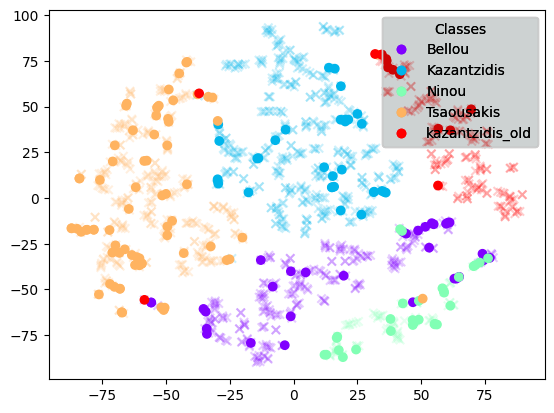

In [78]:
fig, ax = plt.subplots()

scatter = ax.scatter(X_embedded[idxs['train'],0], X_embedded[idxs['train'],1], marker='x', c=ids['train'], cmap='rainbow', alpha=0.2)
scatter = ax.scatter(X_embedded[idxs['test'],0], X_embedded[idxs['test'],1], marker='o', c=ids['test'], cmap='rainbow')
legends = ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
legends.get_frame().set_alpha(None)
legends.get_frame().set_facecolor((0, 0.1, 0.1, 0.1))
for i,t in enumerate(legends.get_texts()):
    t.set_text( id2label[str(i)] )
ax.add_artist(legends)

In [79]:
os.makedirs('figs', exist_ok=True)
fig.savefig('figs/tsne_2sec.png', dpi=300)